In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import warnings
import matplotlib.pyplot as plt
from statsmodels.api import Logit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import plotly.express as px
import pickle
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('case-ifood.csv')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)

In [5]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [6]:
df.dropna(axis=0,inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

## Removendo a coluna de ID

In [9]:
df = df.iloc[:,1:]

## Verificando as frequências das variáveis numéricas

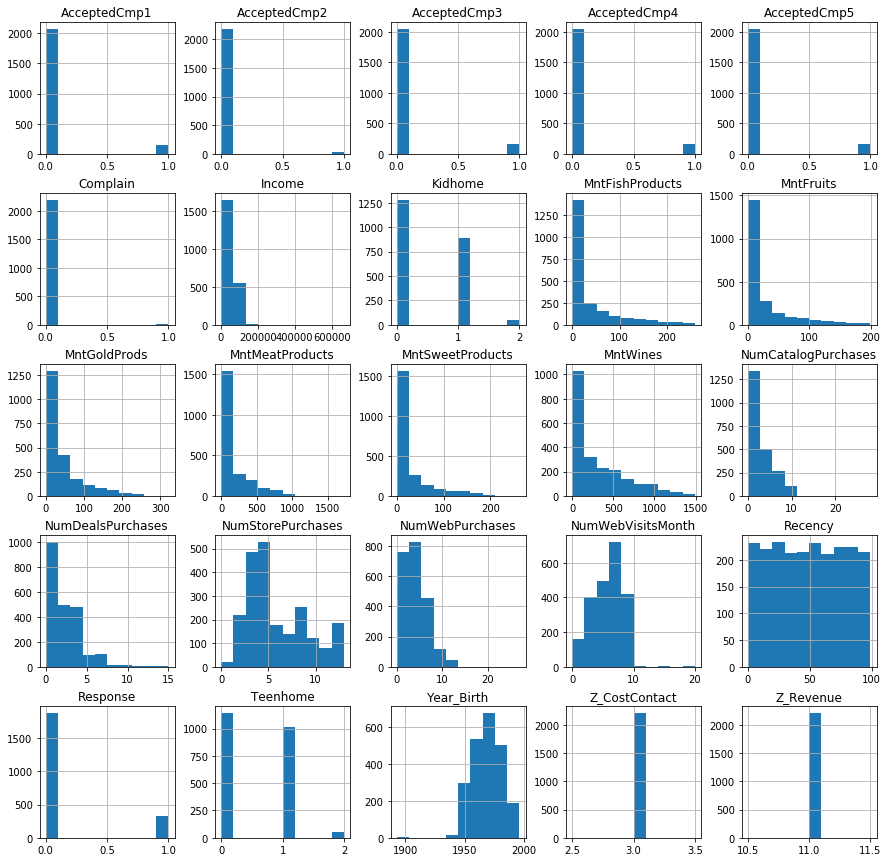

In [10]:
df.hist(figsize=(15,15));

## Variáveis que não vão ser úteis por serem quase um único número:
### Z_CostContact, Z_Revenue, Complain

In [11]:
df = df[[x for x in df.columns if x not in ['Z_CostContact','Z_Revenue','Complain']]]

## Verificando a frequência de cada categoria das variáveis categóricas

In [12]:
for x in ['Education','Marital_Status']:
    print(f'{(df[x].value_counts()/df.shape[0])*100}')

Graduation    50.361011
PhD           21.705776
Master        16.471119
2n Cycle       9.025271
Basic          2.436823
Name: Education, dtype: float64
Married     38.673285
Together    25.857401
Single      21.254513
Divorced    10.469314
Widow        3.429603
Alone        0.135379
YOLO         0.090253
Absurd       0.090253
Name: Marital_Status, dtype: float64


## Removendo as linhas com Marital_Status com frequência abaixo de 1% (Categorias não fazem sentido, por isso as demais linhas perderam a credibilidade de veracidade

In [13]:
df = df[(df['Marital_Status']!='Alone')&(df['Marital_Status']!='Absurd')&(df['Marital_Status']!='YOLO')]

## Verificando a associação das variáveis numéricas com o target

## Criando uma variável com os gastos dos últimos 2 anos em qualquer produto

In [14]:
df['Gastos_totais_2anos'] = df['MntFishProducts']+df['MntMeatProducts']+df['MntFruits']+df['MntSweetProducts']+df['MntWines']+\
                              df['MntGoldProds']

## Criando uma variável que conta o número de vezes que o cliente aceitou qualquer uma das ofertas

In [15]:
resultado_campanhas = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp2']+df['Response']

## Criando uma coluna para o total de compras em campanhas, antes da última campanha

In [16]:
df['total_campanhas_passadas'] = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp2']

In [17]:
len(resultado_campanhas[resultado_campanhas>1])

191

## O produto foi comprado mais de uma vez por 191 pessoas

## É preciso converter a coluna Dt_Customer para um formato que faça mais sentido, vou contar o número de dias da data até a data atual (28/05/2022)

In [18]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [19]:
df['data_atual'] = '2022-05-28'
df['data_atual'] = pd.to_datetime(df['data_atual'])
diferenca = df['data_atual'] - df['Dt_Customer']

df['duracao_cliente'] = [x.days for x in diferenca]

In [20]:
df = df[[x for x in df.columns if x not in ['Dt_Customer','data_atual']]]

In [21]:
numericas = ['Kidhome','Teenhome','Income','MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines',\
            'MntGoldProds','NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases','NumWebVisitsMonth',\
            'Recency','Gastos_totais_2anos','total_campanhas_passadas','duracao_cliente']

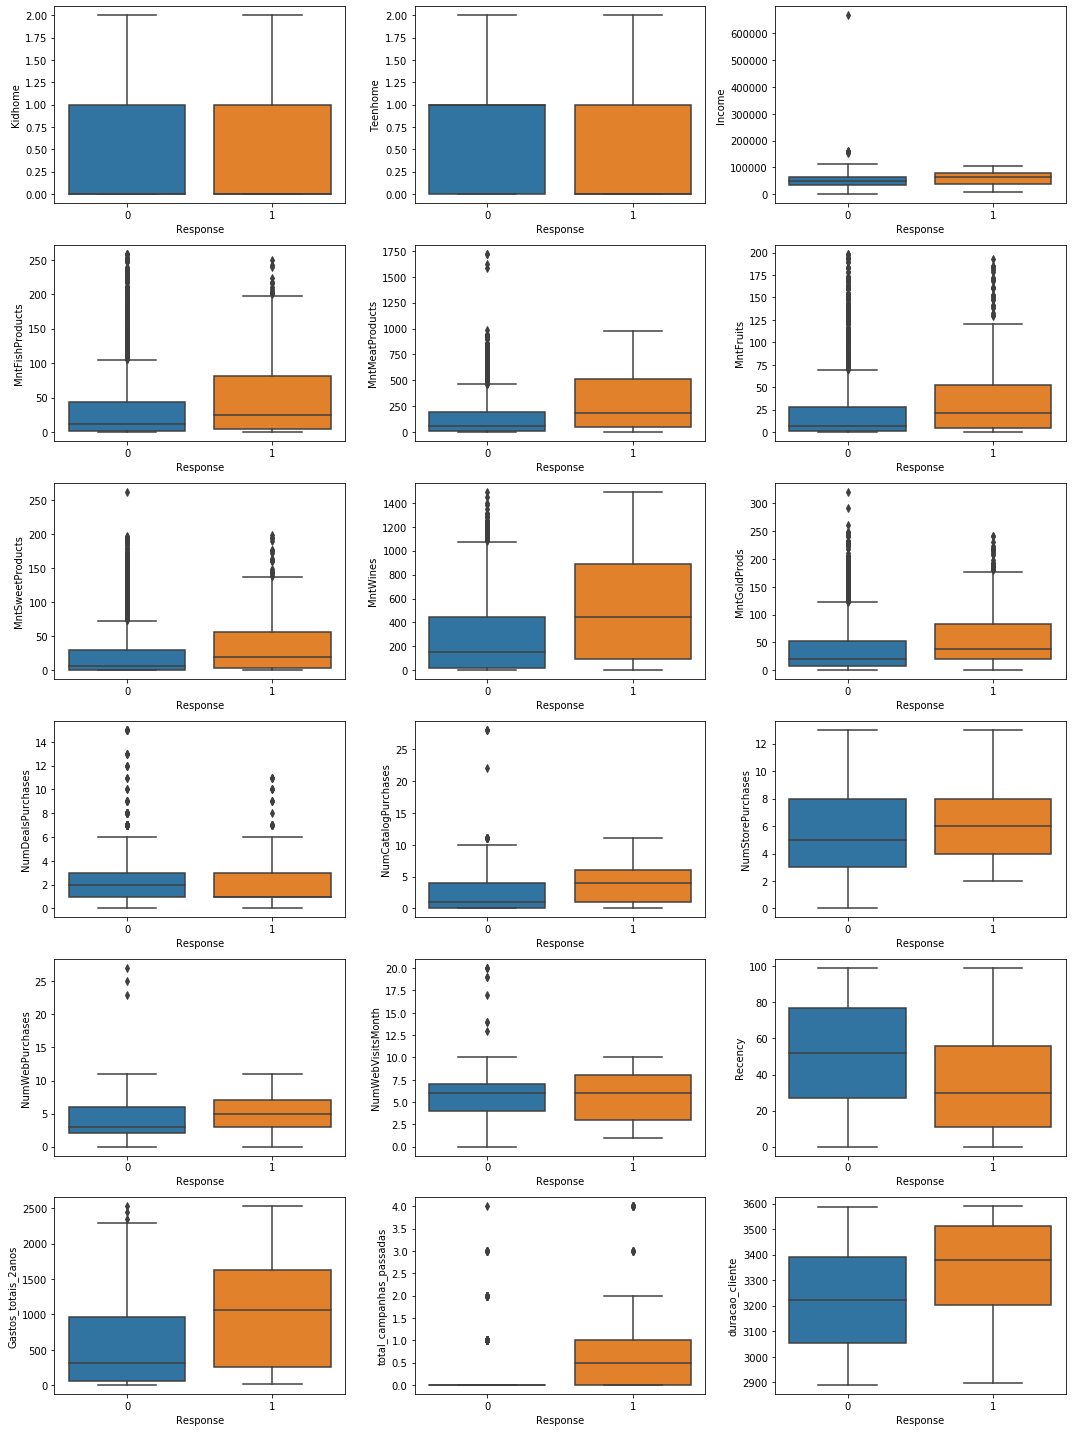

In [22]:
plt.figure(figsize=(15,20))
for indice in range(0,len(numericas)):
    plt.subplot(6,3,indice+1)
    sns.boxplot(y=numericas[indice],x='Response',data=df)
    plt.tight_layout()

## Os clientes que aceitaram a última oferta são clientes mais antigos que os que não compraram

In [23]:
df[['duracao_cliente','Response']].groupby('Response').mean()

,duracao_cliente
Response,
0,3226.816924
1,3338.466667


In [24]:
(df.loc[(df['total_campanhas_passadas']==0)&(df['Response']==1)].shape[0]/(df.loc[(df['total_campanhas_passadas']==0)&(df['Response']==0)].shape[0]+df.loc[(df['total_campanhas_passadas']==0)&(df['Response']==1)].shape[0]))*100

9.116022099447514

## Apenas 9.1% dos clientes que não compraram nas campanhas anteriores compraram na atual. Ou seja, 90,9% dos que não compraram antes, também não compraram na campanha atual

In [25]:
(df.loc[(df['total_campanhas_passadas']>0)&(df['Response']==1)].shape[0]/(df.loc[(df['total_campanhas_passadas']>0)&(df['Response']==0)].shape[0]+df.loc[(df['total_campanhas_passadas']>0)&(df['Response']==1)].shape[0]))*100

41.35338345864661

## Já dentre os que compraram antes, 41.3% voltou a comprar novamente

## A recorrência parece ter um efeito muito positivo (sinal de que o produto é bom)

## Isso significa que os 9.1% atuais que compraram são possíveis leads no futuro

In [26]:
df[['Gastos_totais_2anos','Response']].groupby('Response').mean()

,Gastos_totais_2anos
Response,
0,540.042576
1,989.503030


In [27]:
df['Gastos_totais_2anos'].mean()

607.1869624264373

In [28]:
989.5/607.18

1.629665008728878

In [29]:
989.5/540.04

1.8322716835789943

## Os gastos com produtos nos últimos 2 anos é um bom indicativo de que o cliente fará a compra do produto em campanha. Os que fizeram a compra gastaram em média 83% a mais comparado com os que não compraram e 62% a mais que a média geral

In [30]:
np.quantile(a = df.loc[df['Response']==1,'Recency'],q=0.75)

56.0

## A maior parte (75%) dos clientes que fez a compra do produto se absteve de comprar da empresa por até 56 dias. Passar disso pode ser um indicativo de que não vale a pena divulgar para esse cliente OU perto desse tempo é uma boa hora para fornecer cupons para que o usuário volte consumir os produtos

In [31]:
df.loc[df['Response']==1,'NumStorePurchases'].min()

2

## O número de compras em lojas físicas parece ser um bom indicador de que o cliente vai ou não aderir à campanha. Todos os clientes que compraram 1 ou nenhuma vez em lojas físicas não compraram o produto da campanha

In [32]:
df

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Gastos_totais_2anos,total_campanhas_passadas,duracao_cliente
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,7,0,0,0,0,0,1,1617,0,3553
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,5,0,0,0,0,0,0,27,0,3003
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,4,0,0,0,0,0,0,776,0,3202
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,6,0,0,0,0,0,0,53,0,3029
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,5,0,0,0,0,0,0,422,0,3051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,Graduation,Married,61223.0,0,1,46,709,43,182,...,5,0,0,0,0,0,0,1341,0,3271
2236,1946,PhD,Together,64014.0,2,1,56,406,0,30,...,7,0,0,0,1,0,0,444,1,2909
2237,1981,Graduation,Divorced,56981.0,0,0,91,908,48,217,...,6,0,1,0,0,0,0,1241,1,3045
2238,1956,Master,Together,69245.0,0,1,8,428,30,214,...,3,0,0,0,0,0,0,843,0,3046


## Analisando as campanhas separadamente

In [33]:
campanhas = ['AcceptedCmp'+str(x) for x in range(1,6)]

In [34]:
for x in campanhas:
    df[x] = df[x].astype(object)

In [35]:
df['Response'] = df['Response'].astype(object)

## H0: Não há associação entre as variáveis

In [36]:
for x in campanhas:
    contingencia = pd.crosstab(index=df['Response'],columns=df[x])
    print(f'A probabilidade de erro ao rejeitar H0 entre Response e {x} é: {chi2_contingency(contingencia)[1]*100:.2f}%\n')

A probabilidade de erro ao rejeitar H0 entre Response e AcceptedCmp1 é: 0.00%

A probabilidade de erro ao rejeitar H0 entre Response e AcceptedCmp2 é: 0.00%

A probabilidade de erro ao rejeitar H0 entre Response e AcceptedCmp3 é: 0.00%

A probabilidade de erro ao rejeitar H0 entre Response e AcceptedCmp4 é: 0.00%

A probabilidade de erro ao rejeitar H0 entre Response e AcceptedCmp5 é: 0.00%



## O teste indica que nenhuma das compras anteriores tem associação com a saída

## Como já tenho a coluna total_campanhas_passadas eu não preciso mais das colunas AcceptedCmpX

In [37]:
df = df[[x for x in df.columns if x not in campanhas]]

## Verificando a associação entre a saída e as demais variáveis categóricas

In [38]:
categoricas = [x for x in df.columns if df[x].dtype=='object' and x!='Response']

In [39]:
categoricas

['Education', 'Marital_Status']

In [40]:
for x in categoricas:
    contingencia = pd.crosstab(index=df['Response'],columns=df[x])
    print(f'A probabilidade de erro ao rejeitar H0 entre Response e {x} é: {chi2_contingency(contingencia)[1]*100:.2f}%\n')

A probabilidade de erro ao rejeitar H0 entre Response e Education é: 0.02%

A probabilidade de erro ao rejeitar H0 entre Response e Marital_Status é: 0.00%



## Não há evidência que Education e Marital_Status tenham relação com a saída

## Observando as correlações

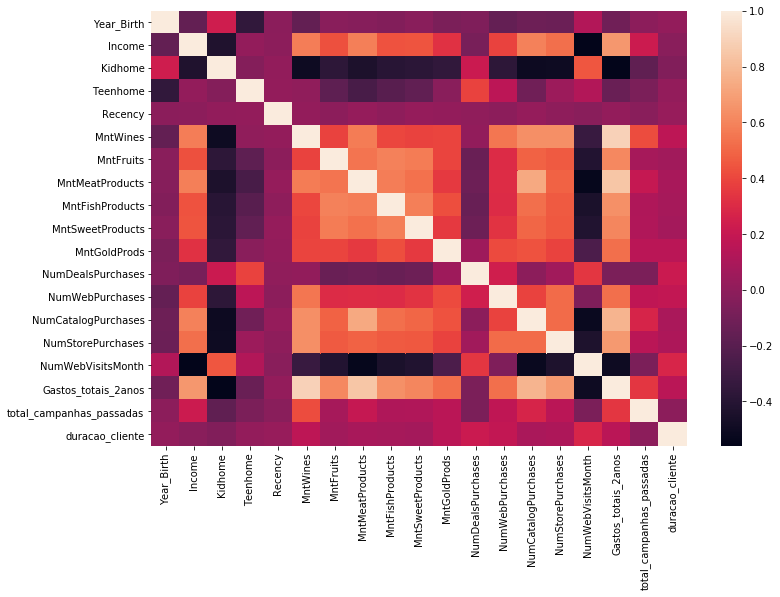

In [41]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr());

In [42]:
correlacoes = df.corr()
repetidas = []

for col in correlacoes.columns:
    for linha in range(correlacoes.shape[0]):
        if correlacoes.index[linha]==col:
            continue
        else:
            if abs(correlacoes[col].iloc[linha])>0.65 and (correlacoes.index[linha],col) not in repetidas and (col,correlacoes.index[linha]) not in repetidas:
                print(f'{col} e {correlacoes.index[linha]} tem correlação de {correlacoes[col].iloc[linha]:.2f}')
                repetidas.append((correlacoes.index[linha],col))
                repetidas.append((col,correlacoes.index[linha]))

Income e Gastos_totais_2anos tem correlação de 0.67
MntWines e Gastos_totais_2anos tem correlação de 0.89
MntMeatProducts e NumCatalogPurchases tem correlação de 0.74
MntMeatProducts e Gastos_totais_2anos tem correlação de 0.85
NumCatalogPurchases e Gastos_totais_2anos tem correlação de 0.78
NumStorePurchases e Gastos_totais_2anos tem correlação de 0.68


## Como o Gastos_totais_2anos deriva das quantias gastas em cada produto, há um forte correlação dele com essas variáveis. Ou mantenho ela, ou as demais variáveis. (Decidi manter as demais variáveis de gastos)

## Criando um modelo com o statsmodels para determinar as variáveis mais importantes (p value abaixo de 0.05)

In [99]:
encod = LabelEncoder()
for x in categoricas:
    df[x] = encod.fit_transform(df[x])

In [100]:
x = df[[x for x in df.columns if x not in ['Gastos_totais_2anos','Response']]]
y = df[['Response']]

In [101]:
x = sm.add_constant(x)
modelo = Logit(y.astype(float),x).fit()

Optimization terminated successfully.
         Current function value: 0.276283
         Iterations 8


In [102]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 2209
Model:                          Logit   Df Residuals:                     2188
Method:                           MLE   Df Model:                           20
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                  0.3448
Time:                        16:35:48   Log-Likelihood:                -610.31
converged:                       True   LL-Null:                       -931.42
Covariance Type:            nonrobust   LLR p-value:                3.598e-123
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.9295     13.108     -0.223      0.823     -28.622      22.763
Year_Birth                  -0.0059      0.007     -0.893      0.372      -0.019       0.007
Education                    0.3748      0.076      4.955      0.000       0.227       0.523
Marital_Status              -0.0568      0.071     -0.801      0.423      -0.196       0.082
Income                    4.641e-07   3.48e-06      0.133      0.894   -6.35e-06    7.28e-06
Kidhome                      0.2545      0.205      1.241      0.215      -0.147       0.657
Teenhome                    -1.0700      0.194     -5.526      0.000      -1.449      -0.691
Recency                     -0.0295      0.003    -10.323      0.000      -0.035      -0.024
MntWines                     0.0001      0.000      0.315      0.753      -0.001       0.001
MntFruits                    0.0025      0.002      1.094      0.274      -0.002       0.007
MntMeatProducts              0.0022      0.000      4.451      0.000       0.001       0.003
MntFishProducts             -0.0025      0.002     -1.394      0.163      -0.006       0.001
MntSweetProducts             0.0023      0.002      1.048      0.294      -0.002       0.007
MntGoldProds                 0.0030      0.002      2.010      0.044    7.64e-05       0.006
NumDealsPurchases            0.0793      0.046      1.716      0.086      -0.011       0.170
NumWebPurchases              0.0987      0.032      3.090      0.002       0.036       0.161
NumCatalogPurchases          0.0510      0.041      1.236      0.216      -0.030       0.132
NumStorePurchases           -0.1804      0.034     -5.383      0.000      -0.246      -0.115
NumWebVisitsMonth            0.0653      0.047      1.377      0.168      -0.028       0.158
total_campanhas_passadas     1.5020      0.130     11.544      0.000       1.247       1.757
duracao_cliente              0.0037      0.000      8.410      0.000       0.003       0.005
============================================================================================
"""

## Variáveis menos importantes para prever a saída de acordo com o modelo:
## Year_Birth, Marital_Status, Income, Kidhome, MntWines, MntFruits, MntFishProducts, MntSweetProducts, NumCatalogPurchases, NumWebVisitsMonth

## Testando um novo modelo, só com as variáveis que ele apontou como mais importantes

In [109]:
df_novo = df[[x for x in df.columns if x not in ['Year_Birth', 'Marital_Status', 'Income', 'Kidhome', 'MntWines', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'NumCatalogPurchases', 'NumWebVisitsMonth','Gastos_totais_2anos']]]

In [110]:
df_novo

,Education,Teenhome,Recency,MntMeatProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumStorePurchases,Response,total_campanhas_passadas,duracao_cliente
0,2,0,58,546,88,3,8,4,1,0,3553
1,2,1,38,6,6,2,1,2,0,0,3003
2,2,0,26,127,42,1,8,10,0,0,3202
3,2,0,26,20,5,2,2,4,0,0,3029
4,4,0,94,118,15,5,5,6,0,0,3051
...,...,...,...,...,...,...,...,...,...,...,...
2235,2,1,46,182,247,2,9,4,0,0,3271
2236,4,1,56,30,8,7,8,5,0,1,2909
2237,2,0,91,217,24,1,2,13,0,1,3045
2238,3,1,8,214,61,2,6,10,0,0,3046


## Usando o onehot encoder para codificar melhor as variáveis categóricas

In [115]:
onehot = OneHotEncoder(sparse=False)
cod_vars = onehot.fit_transform(df_novo[['Education']])

In [117]:
scaler = StandardScaler()
df_novo[[x for x in df_novo.columns if x not in ['Response','Education']]] = scaler.fit_transform(df_novo[[x for x in df_novo.columns if x not in ['Response','Education']]])

In [119]:
x_novo = df_novo[[x for x in df_novo.columns if x not in ['Education','Response']]]
x_novo_final = np.concatenate([x_novo.values,cod_vars],axis=1)

In [120]:
y = df['Response'].astype('int').values

In [125]:
modelos = [('Reg.Log',LogisticRegression()),('NaiveB',GaussianNB()),('XGBoost',XGBClassifier(eval_metric='logloss')),('Rand.f',RandomForestClassifier())]

In [126]:
kf = KFold(n_splits=10)
resultado = []

for nome,modelo in modelos:
    resultado.append(cross_val_score(modelo,x_novo_final,y,cv=kf,scoring='neg_mean_squared_error'))

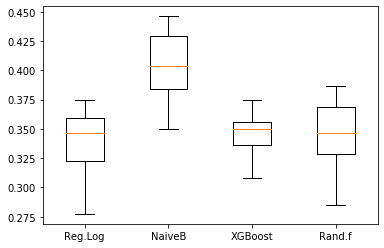

In [127]:
plt.boxplot([x for x in (-np.array(resultado))**0.5],labels=[x for x,y in modelos]);

## RandomForest e LogisticRegression tiveram os melhores desempenhos

## Tentando melhorar o RandomForest e a Regressão Logística com o AdaBoost

In [128]:
modelos = [('Reg.Log',AdaBoostClassifier(LogisticRegression(),n_estimators=200)),('Rand.f',AdaBoostClassifier(RandomForestClassifier(),n_estimators=200)),
          ('XGBoost',XGBClassifier(eval_metric='logloss'))]

kf = KFold(n_splits=10)
resultado = []

for nome,modelo in modelos:
    resultado.append(cross_val_score(modelo,x_novo_final,y,cv=kf,scoring='neg_mean_squared_error'))

Text(0.5, 1.0, 'Resultado com AdaBoost em 200 estimators')

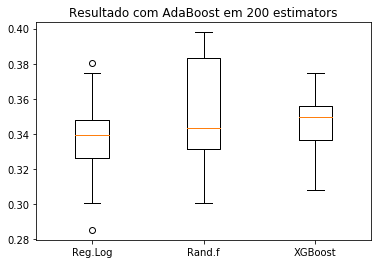

In [129]:
plt.boxplot([x for x in (-np.array(resultado))**0.5],labels=[x for x,y in modelos])
plt.title('Resultado com AdaBoost em 200 estimators')

## O melhor resultado foi obtido com consistência pela Regressão Logística

In [130]:
resultado_rl.mean()

0.8809461127108186

## Fazendo o tuning do LogisticRegression

In [131]:
params = {'penalty':['l1','l2'],
         'C':[0.8,0.7,1.1,1.2]}

In [132]:
grid_search_rl = GridSearchCV(LogisticRegression(),param_grid=params,n_jobs=-1,cv=kf,scoring='neg_mean_squared_error')
grid_search_rl.fit(x_novo_final,y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.8, 0.7, 1.1, 1.2], 'penalty': ['l1', 'l2']},
             scoring='neg_mean_squared_error')

In [133]:
grid_search_rl.best_params_

{'C': 0.8, 'penalty': 'l2'}

In [134]:
grid_search_rl.best_score_

-0.11542986425339367

## Fazendo o tuning do AdaBoost

In [135]:
params = {'n_estimators':[50,100,200,500],
         'learning_rate':np.arange(0.1,1,0.05)}

In [136]:
grid_search_rl = GridSearchCV(AdaBoostClassifier(LogisticRegression(C=0.8)),param_grid=params,n_jobs=-1,cv=kf,scoring='neg_mean_squared_error')
grid_search_rl.fit(x_novo_final,y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=LogisticRegression(C=0.8)),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': [50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [137]:
grid_search_rl.best_params_

{'learning_rate': 0.8500000000000002, 'n_estimators': 500}

In [138]:
grid_search_rl.best_score_

-0.1140744549568079

## Salvando o modelo final

In [168]:
modelo_final = LogisticRegression(C=0.8)
modelo_final.fit(x_novo_final,y)

with open('modelo_final.pkl','wb') as f:
    pickle.dump(modelo_final,f)

## Não houve ganho com o AdaBoost, vou usar o LogisticRegression sozinho

## Reverificando as variáveis mais importantes para ajudar na análise do negócio

In [148]:
x_randf = df_novo[[x for x in df_novo.columns if x!='Response']]

In [149]:
randf = RandomForestClassifier(n_estimators=100)
randf.fit(x_randf.values,y)

RandomForestClassifier()

In [153]:
imports = pd.DataFrame({'Variável':x_randf.columns,'Importância':randf.feature_importances_}).sort_values('Importância',ascending=False)
imports

,Variável,Importância
9,duracao_cliente,0.158778
2,Recency,0.156300
3,MntMeatProducts,0.155174
8,total_campanhas_passadas,0.133862
4,MntGoldProds,0.111800
7,NumStorePurchases,0.086743
6,NumWebPurchases,0.066915
5,NumDealsPurchases,0.055683
0,Education,0.046209
1,Teenhome,0.028535


In [163]:
px.line(imports,x='Variável',y='Importância',title='Variáveis mais importantes')

## A seguinte árvore de decisão foi criada com os pacotes rpart e rpart.plot em R (Código em anexo) para ajudar a entender o fluxo do cliente que aceita a oferta da campanha. 1 aceita, 0 rejeita

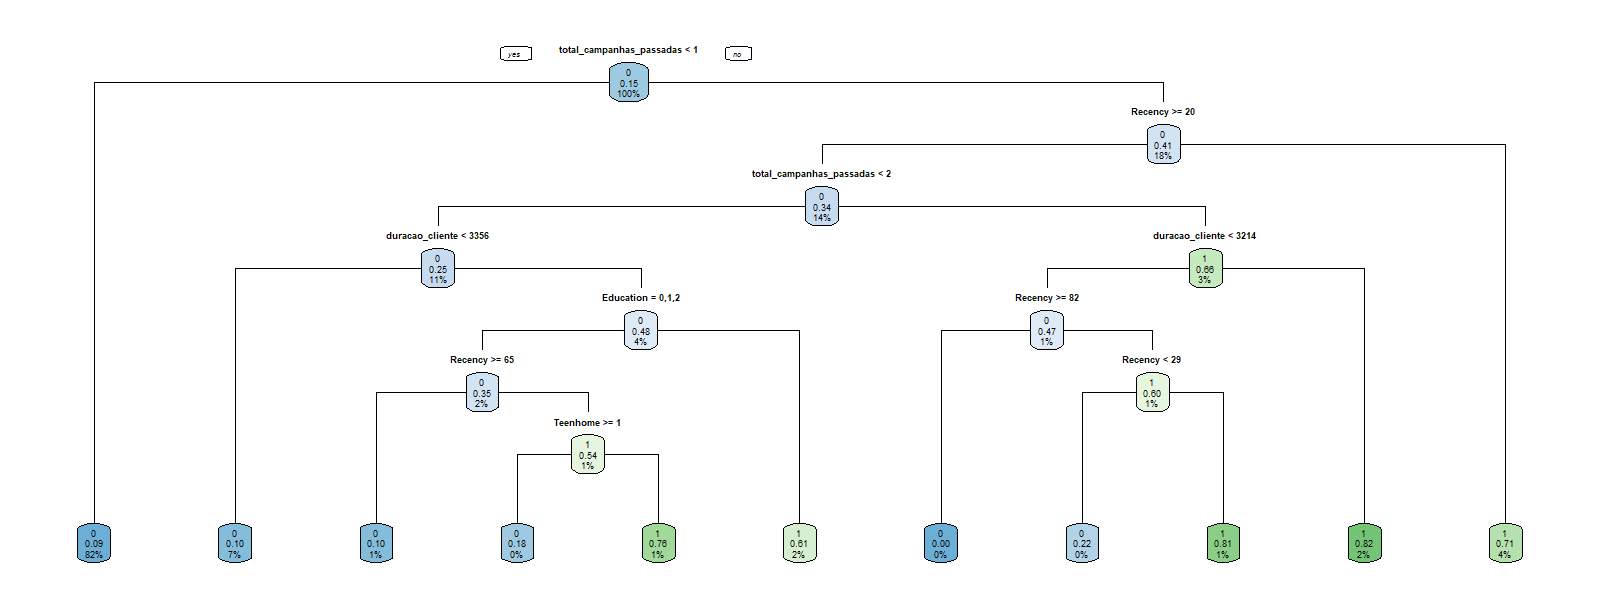

## Fazendo a Clusterização dos clientes com KMeans

In [218]:
df_clust = df_novo[[x for x in df_novo.columns if x !='Response']]

In [219]:
wcss = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_clust[[x for x in df_clust.columns if x !='Response']])
    labels = kmeans.predict(df_clust[[x for x in df_clust.columns if x !='Response']])
    
    print(f'Silhouete Score para k={k}:{silhouette_score(df_clust,labels=labels):.2f}')
    wcss.append((k,kmeans.inertia_))

Silhouete Score para k=2:0.19
Silhouete Score para k=3:0.20
Silhouete Score para k=4:0.13
Silhouete Score para k=5:0.14
Silhouete Score para k=6:0.14
Silhouete Score para k=7:0.14
Silhouete Score para k=8:0.14
Silhouete Score para k=9:0.13


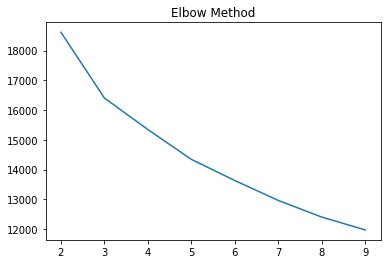

In [195]:
k,inertia = zip(*wcss)
plt.plot(k,inertia)
plt.title('Elbow Method');

## 3 parece ser um bom k

In [182]:
pca = PCA(2)
comps = pca.fit_transform(df_clust[[x for x in df_clust.columns if x !='Response']])

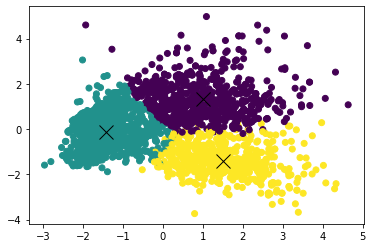

In [207]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(df_clust[[x for x in df_clust.columns if x !='Response']])
plt.scatter(comps[:,0],comps[:,1],c=labels);

for x,y in pca.transform(kmeans.cluster_centers_):
    plt.plot(x,y,marker='x',color='black',lw=10,markersize=14)

## A descrição dos grupos vai ser adicionada em breve